# Heat equation - Retrieving operator through ODE solving

In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchdiffeq import odeint_adjoint as odeint

In [2]:
from utils.graphic_tools import simple_plotter, show_state, animate_plot, visualize_u_from_F
from utils.analysis_tools import relative_err, rmse, check_weights, downsampling
from utils.models import HeatModel

from equations.heat import get_heat, get_heat_grad_t, get_heat_fd, get_heat_fd_impl
from equations.initial_functions import random_init, high_dim_random_init, heat_analytical_init

from generators import heat_snapshot_generator, get_heat_batch
from training_dataset import generate_heat_training_dataset, read_dataset

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

<IPython.core.display.Javascript object>


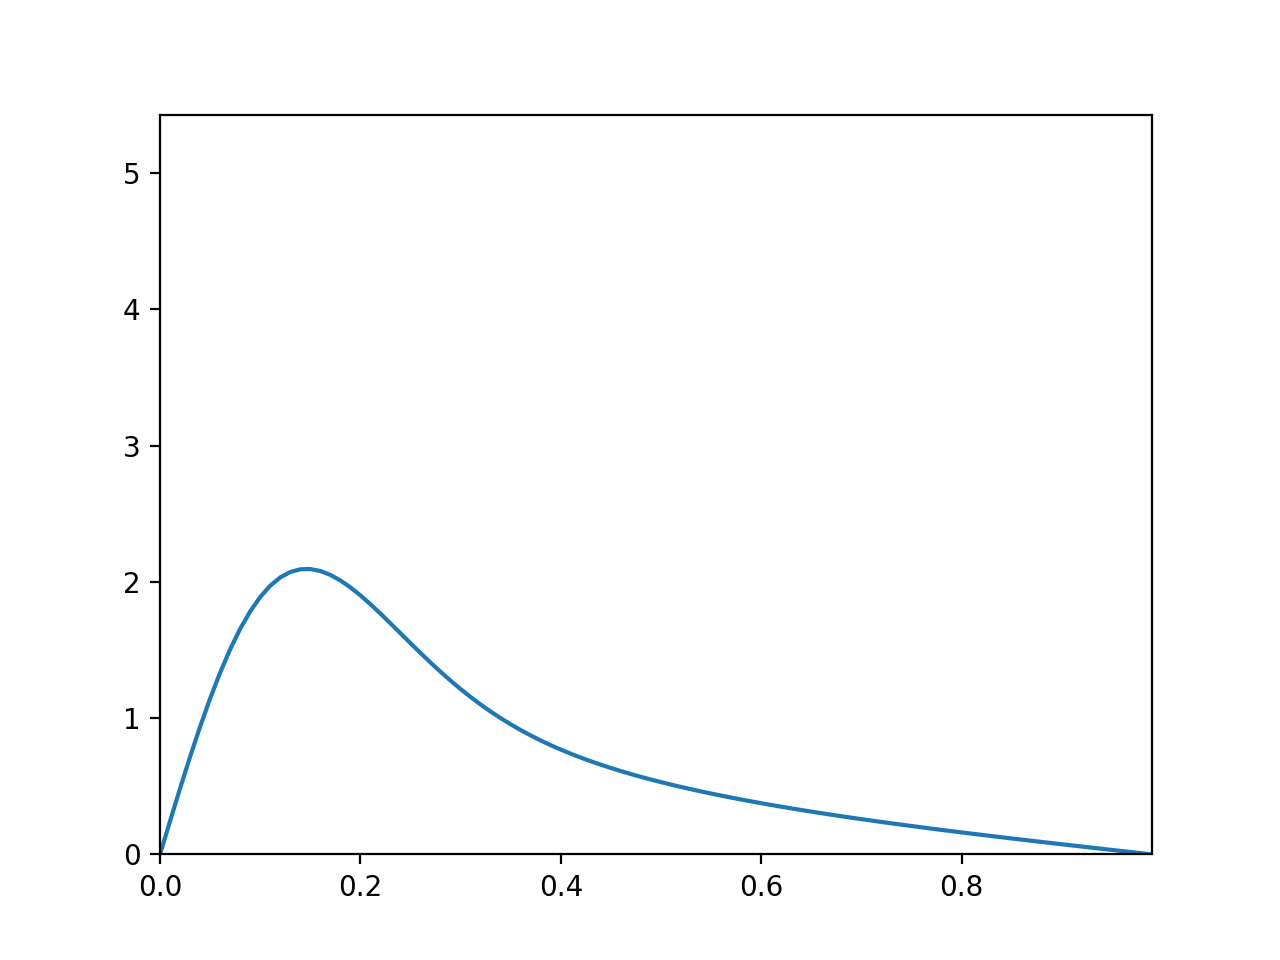

In [3]:
%matplotlib notebook

u_true, cn = get_heat(0.01, 0.001, 1., 0., 50, 100, False)
g_u_true = get_heat_grad_t(0.01, 0.001, 1., 0., 20, 50, cn)

x = np.arange(0.0, 1.0, 0.01)
outer_ani = animate_plot(u_true, x)

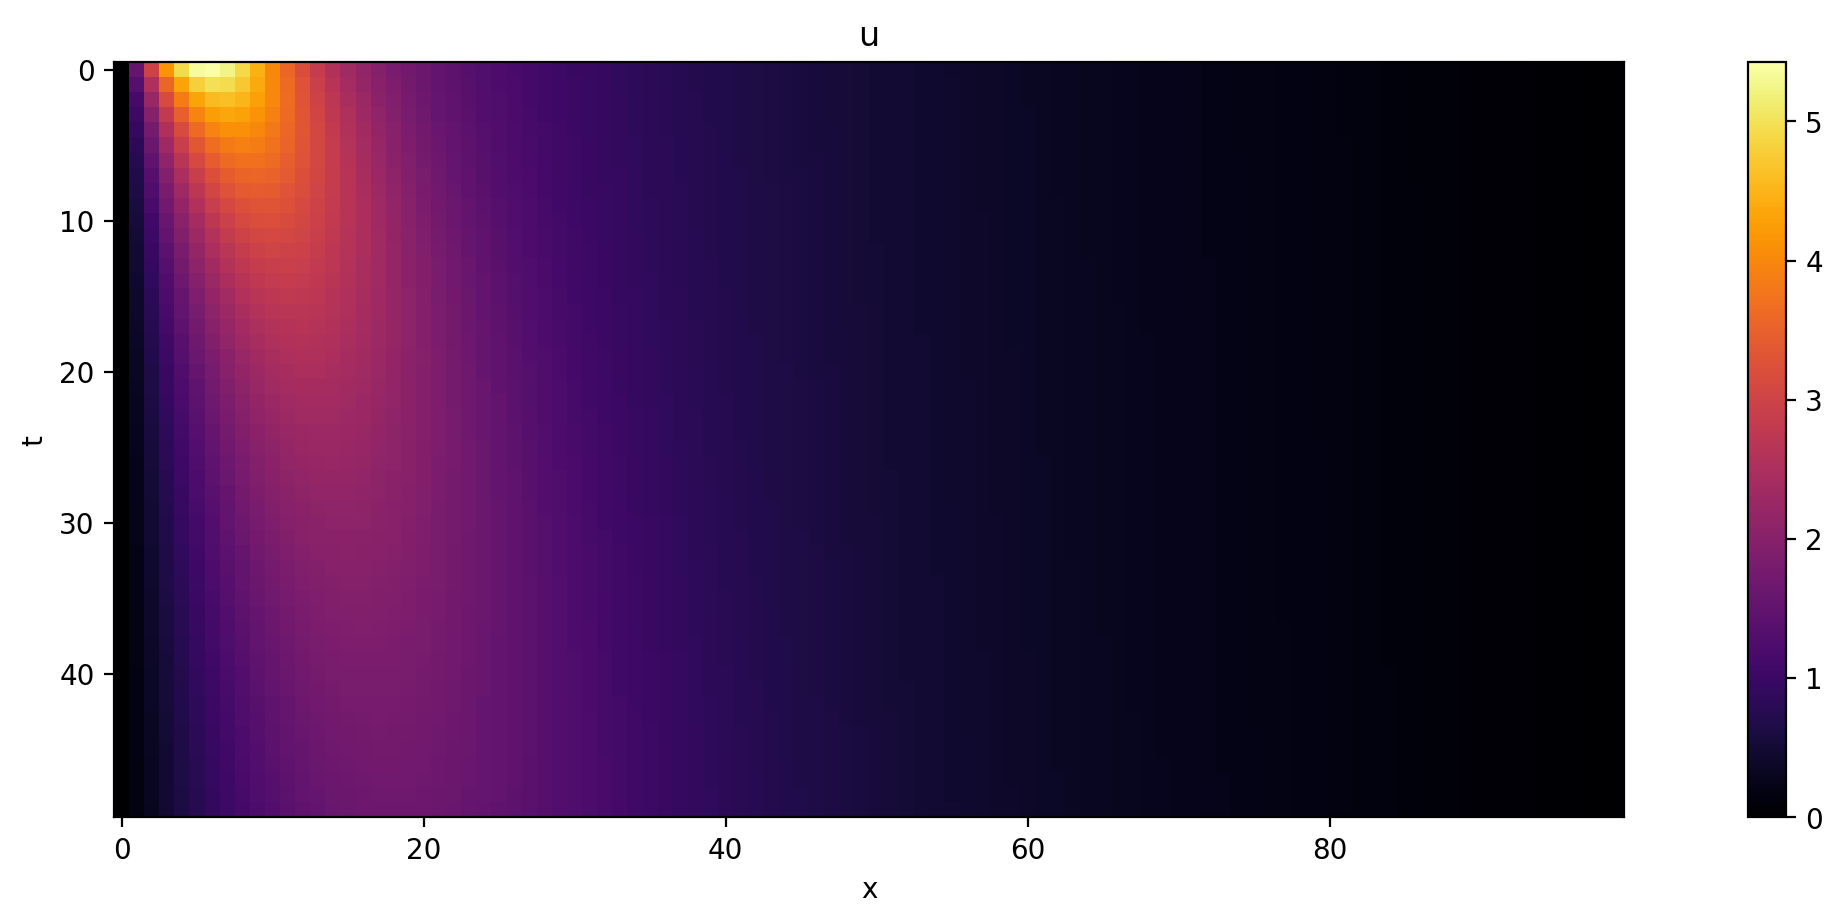

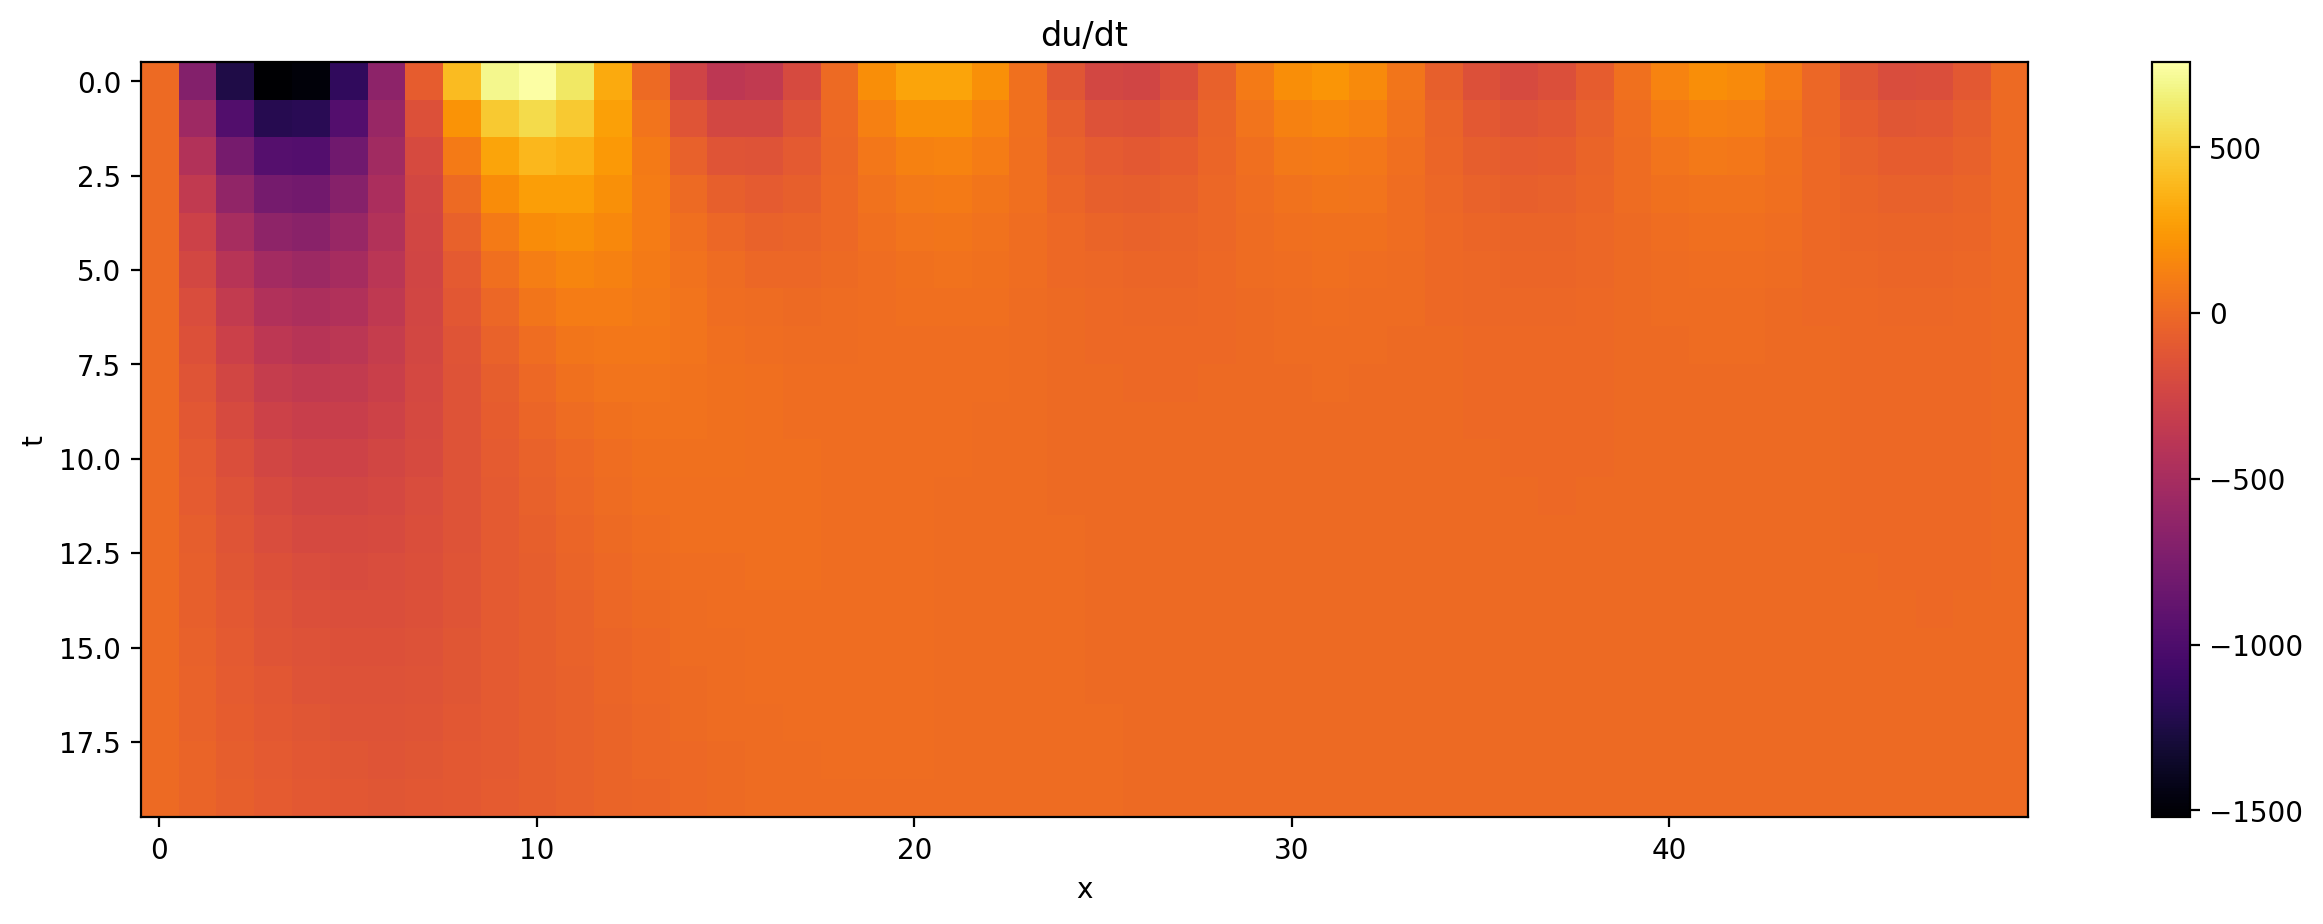

In [4]:
%matplotlib inline
show_state(u_true, 'u')
show_state(g_u_true, 'du/dt')

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well explicit, implicit finite-difference and finite-element solutions.

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with the implicit finite-difference, a numerically stable solution for a large range of parameters.

In [5]:
t_max = 0.5
t_min = 0.01
x_max = 1.
x_min = 0.
t_n = 64
x_n = 64

(64, 66)


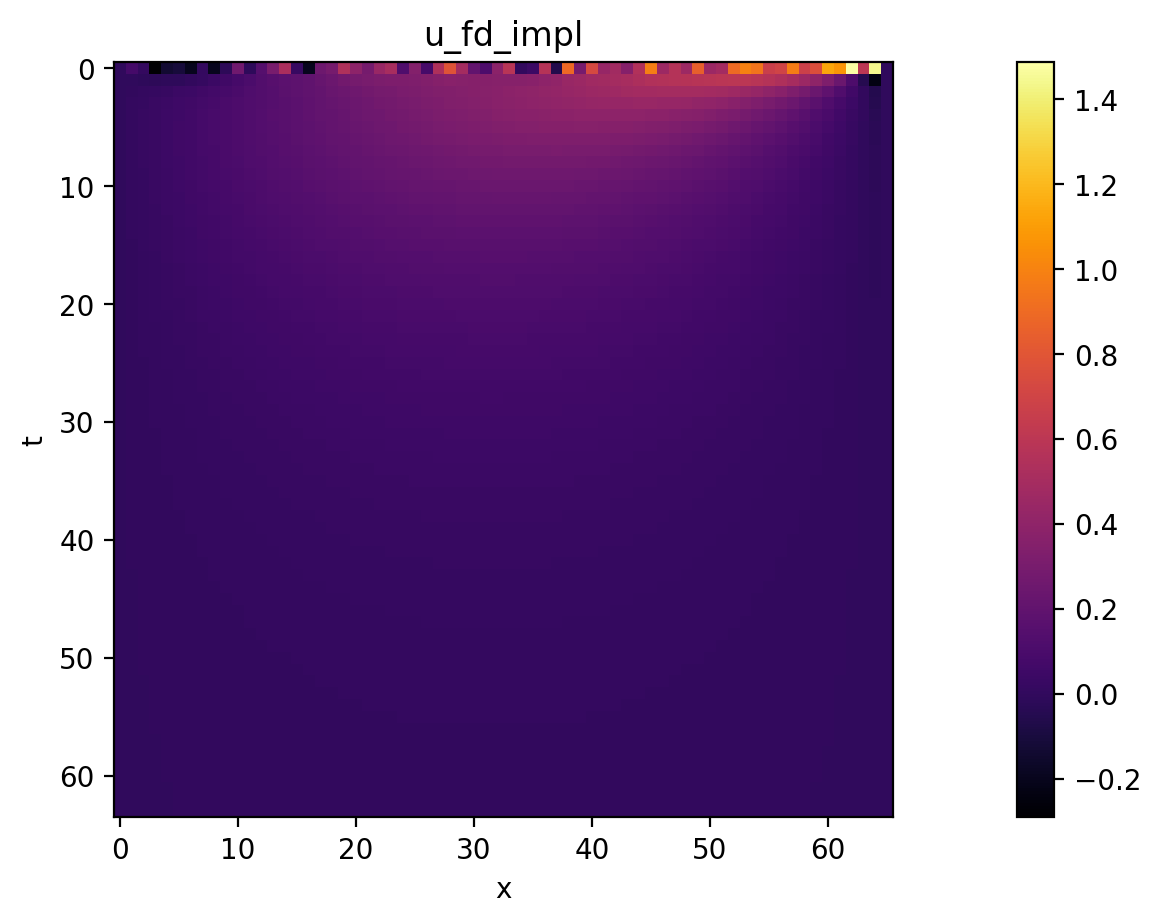

In [6]:
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

u0 = random_init(t, x)
print(u0.shape)
u_fd_impl, _ = get_heat_fd_impl(dt, dx, t_n, x_n, u0)
show_state(u_fd_impl, 'u_fd_impl')

# Keep initial conditions. Change if start from t=1
# u_fd, _ = get_heat_fd(dt, dx, t_n, x_n, u0)
# show_state(u_fd, 'u_fd')

---

### Full-order model - Coarse grid

Several training datasets of high-dimension are generated, downsampled and compare to coarse grid solution as a point of comparison.

In [7]:
# training_set = generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 256, 0, './dataset/random_heat_training_set.pt')
training_set = read_dataset('dataset/random_heat_training_set.pt')

In [8]:
def coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, dataset):
    batch_size = len(dataset)
    
    t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
    x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

    rmse_tot = 0
    re_tot = 0
    for i in range(batch_size):
        # Get downsize solution
        t, u, _, _ = dataset[i]
        u = u.detach().numpy()
        
        # Generate coarse grid solution
        u0 = np.zeros((t_n, x_n + 2))
        u0[0, 1:-1] = u[0, :]
        pred_u, _ = get_heat_fd_impl(dt, dx, t_n, x_n, u0)
        
        # Compute rmse and relative error
        re_tot += relative_err(u.T, pred_u[:, 1:-1].T)
        rmse_tot += rmse(pred_u[:, 1:-1].T, u.T)
        
#         if (i % 50):
#             show_state(np.abs(pred_u[:, 1:-1].T - u.T), 'Error NN vs. Real', 't', 'x', None)
#             show_state(u.T, 'Real', 't', 'x', None)
#             show_state(pred_u[:, 1:-1].T, 'Expected', 't', 'x', None)
    
    print(rmse_tot / batch_size)
    print(np.mean(re_tot) / batch_size)
    

coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, training_set)

0.11066477085513832
0.6907384966480148


---

## Operator F reconstruction

### Model used by ODE solver

Model registered in models.py under HeatModel name.

In [9]:
class ODEModel(nn.Module):
    def __init__(self, n):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, n),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

Let's write a small training loop for our neural ode.

In [10]:
def dudt(u, dt):
    return u[1:, :] - u[0:-1, :] / dt

#### Training loop - ode solver & intrusive training

In [11]:
def loss_fn(pred_x, x):
    return nn.MSELoss(reduction='sum')(pred_x, x)

In [12]:
def training_ode_solver_net(net, epochs, t_n, x_n, dataset, val_epoch=10, rands=[], downsize=0):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    training_batch_size = len(dataset)
    training_set_idx = np.arange(0, training_batch_size)
    
    tr_min_t = 1
    tr_max_t = int(len(dataset[0][0]) / 5 * 2)
    val_max_t = int(tr_max_t + len(dataset[0][0]) / 5 * 2)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        # === Train ===
        net.train()
        np.random.shuffle(training_set_idx)
        for i in training_set_idx:
            # === Randomness ====
            rand = -1
            if (i < len(rands)):
                rand = rands[i]
    
            optimizer.zero_grad()
            
            t, bu, _, _ = dataset[i]
            tr_t =  t[tr_min_t:tr_max_t]
            tr_b0 = bu[tr_min_t, :]
            tr_bu = bu[tr_min_t:tr_max_t, :]
            
            pred_u = odeint(net, tr_b0, tr_t) # [1:-1]
            loss = loss_fn(pred_u.T, tr_bu.T) # [:, 1:-1]
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()
        
        print('Epoch %d loss %f'%(e, float(loss_tot / float(training_batch_size))))
        
        # === Evaluate ===
        net.eval()
        if (e > val_epoch):
            for j in training_set_idx:
                t, bu, _, _ = dataset[j]
                val_t = t[tr_max_t:val_max_t]
                val_b0 = bu[tr_max_t, :]
                val_bu = bu[tr_max_t:val_max_t, :]
                
                val_pred_u = odeint(net, val_b0, val_t)
                val_loss = loss_fn(val_pred_u.T, val_bu.T)
                val_loss_tot += val_loss.item()
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))
        
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, rand, -1)
            sample_b0 = sample_real[1, :]
            sample_pred = odeint(net, sample_b0[1:-1], sample_t[1:])
            show_state(sample_real[1:].T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

Epoch 1 loss 40.588827
Epoch 2 loss 19.659530
Epoch 3 loss 10.634926
Epoch 4 loss 6.310839
Epoch 5 loss 4.186305
Epoch 6 loss 3.118837
Epoch 6 validation loss 5.250317
Epoch 7 loss 2.591087
Epoch 7 validation loss 5.665133
Epoch 8 loss 2.336880
Epoch 8 validation loss 5.865145
Epoch 9 loss 2.209810
Epoch 9 validation loss 5.910173
Epoch 10 loss 2.147626
Epoch 10 validation loss 5.903185


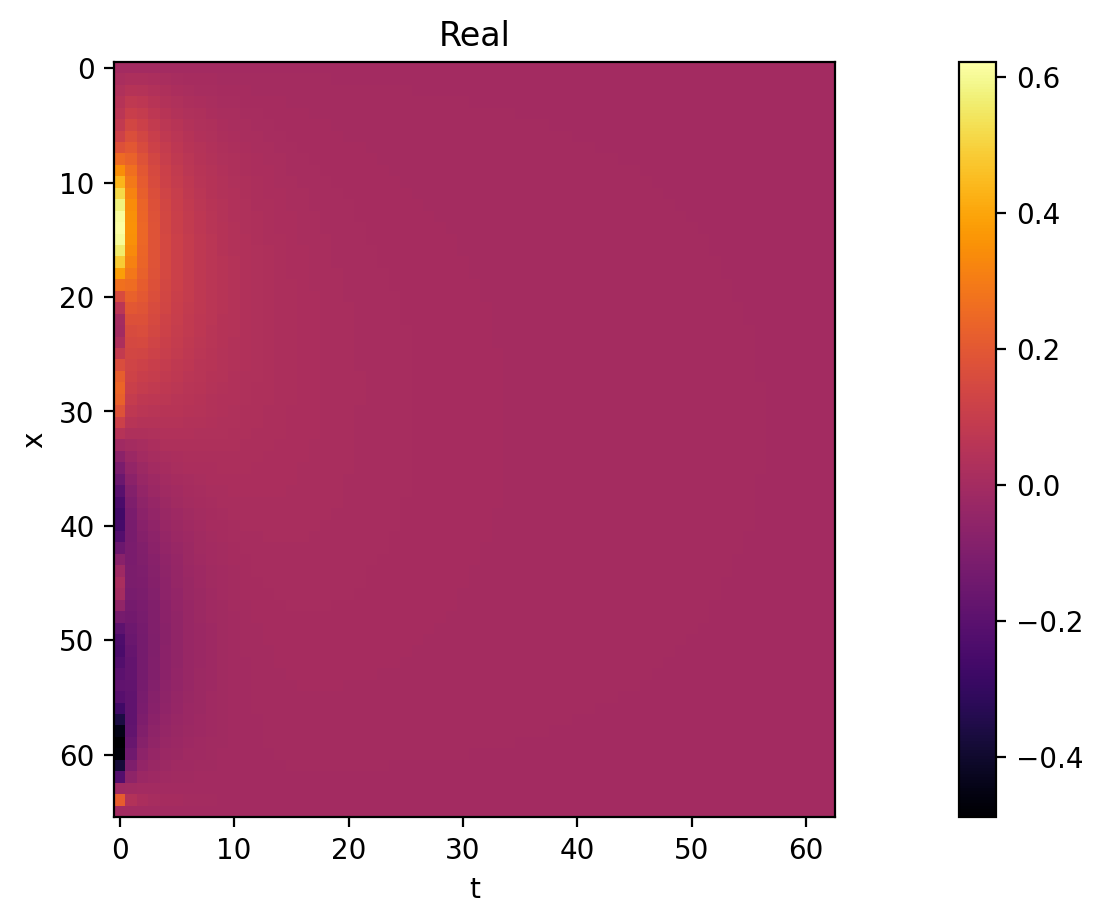

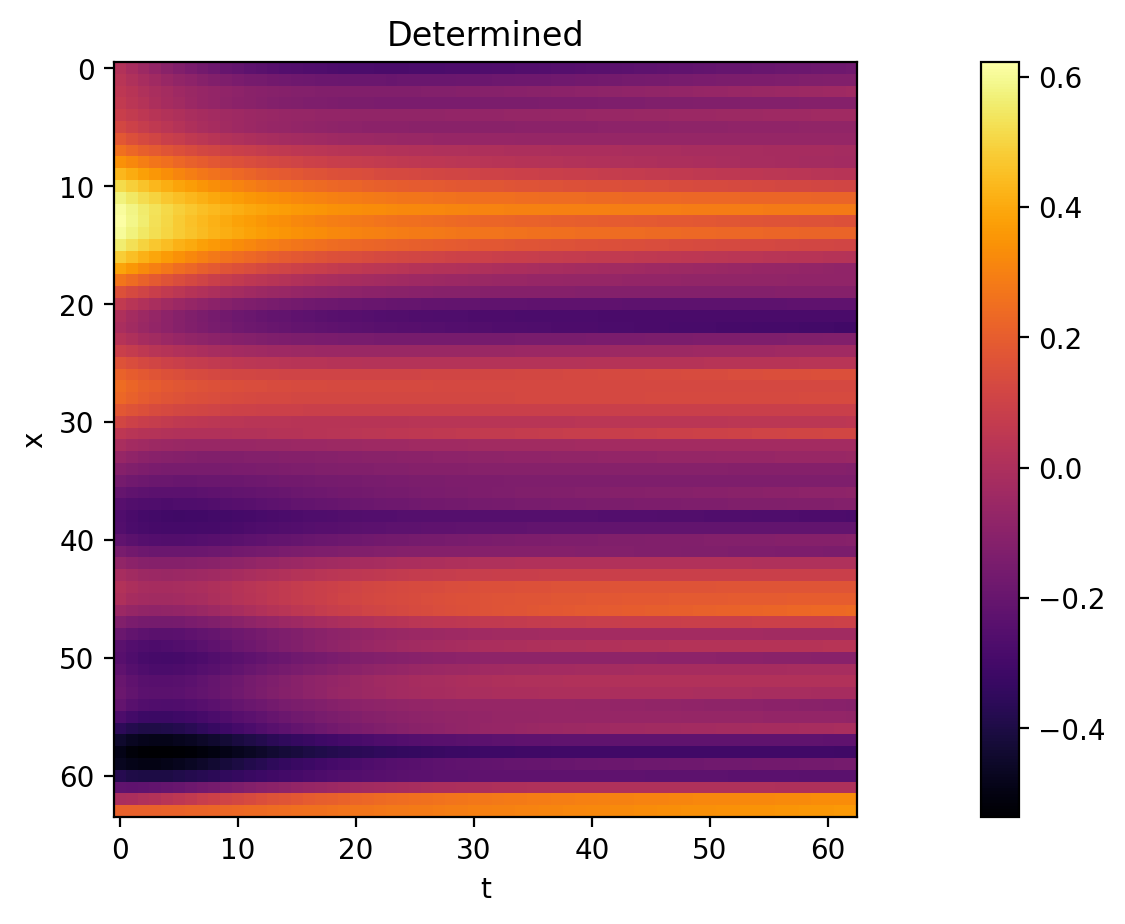

In [14]:
%matplotlib inline
net = HeatModel(x_n)
F = training_ode_solver_net(net, 10, t_n, x_n, training_set[:64], 5, [], 0)

In [ ]:
net2 = HeatModel(x_n)
F2 = training_ode_solver_net(net2, 20, t_n, x_n, training_set, 10, [], 0)

#### Training loop - derivative & non-intrusive training

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10, val_epoch=10, rand=-1):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        
        for i in range(batch_size):
            # === Randomness ====
            rand = -1
            if (i < len(rands))
                rand = rands[i]
            
            # === Train ===
            net.train()
            optimizer.zero_grad()
            
            t, b0, bu = get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_n, rand)
            dudt_ref = dudt(bu[:, 1:-1], (t_max - t_min) / t_n)
            pred_dudt = net([], bu[:-1, 1:-1])
            loss = loss_fn(pred_dudt.T, dudt_ref.T)
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

            # === Evaluate ===
            if (e > val_epoch):
                net.eval()
                val_t, val_b0, val_bu = get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_n, rand)
                val_dudt_ref = dudt(val_bu[:, 1:-1], (t_max - t_min) / t_n)
                val_pred_dudt = net([], val_bu[:-1, 1:-1])
                val_loss = loss_fn(val_pred_dudt.T, val_dudt_ref.T)
                val_loss_tot += val_loss.item()
                
            
        if e % 10 == 0:
            print('Epoch %d loss %f'%(e, float(loss_tot / float(batch_size))))
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(batch_size))))
    
    return net

In [ ]:
%matplotlib inline
net2 = ODEModel(x_n)
F2 = training_ode_solver_net(net2, 300, t_n, x_n, 64, 5, False)

## Visualization

Let's train this basic NN and visualize its efficiency to match the solution u(t,x)

In [ ]:
def check_efficiency(net, n_sim=10, debug=False):
    rmse_tot = 0
    
    for i in range(n_sim):
        t, b0, bu = get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, -1, -1)
        pred_u = odeint(net, b0[1:-1], t).detach().numpy()
        u = bu[:,1:-1].detach().numpy()
        rmse_tot += rmse(pred_u.T, u.T)

        if debug:
            print("RMSE = ", rmse(pred_u.T, u.T))
            show_state(np.abs(pred_u.T - u.T), 'Error NN vs. Real', 't', 'x', None)
            show_state(u.T, 'Real', 't', 'x', None)
            show_state(pred_u.T, 'Expected', 't', 'x', None)
            
    return rmse_tot / n_sim

print(check_efficiency(F, 20, False))

In [ ]:
check_weights(F)

---

## Analysis

It is time to experiment reconstruction through different variants of our problem:
- Introduce different type initial conditions (gaussian, high dimensional)
- Introduce noise
- Switch to a reduce order model (ROM) such as the simple POD.
- Investigate the choice of the NN model.

It would be interesting to evaluates these questions:
- How stable is the inversion considering the noise in temperature and measurement of the flux?
- Which conditions are required to uniquely determine the original data?

#### FOM

Coarse-grid resolution: 
- $t_{max} = 0.5$
- $x_{max} = 1.0$
- $t_n = 64$
- $x_n = 64$

#### Initial conditions


#### Boundary conditions

- Dirichlet: $u(t, a) = u(t, b) = 0, a <= x <= b$